In [1]:
import numpy as np
import pandas as pd

import arviz as az
import corner

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfd = tfp.distributions
tfb = tfp.bijectors

2022-06-02 17:21:18.027116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-02 17:21:18.027131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import bilby

from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

In [4]:
label = 'GW150914'
time_of_event = bilby.gw.utils.get_event_time(label)

In [5]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

In [6]:
H1_data = TimeSeries.fetch_open_data("H1", time_of_event, 
                                     time_of_event + 2,
                                     sample_rate=4096, cache=True)

L1_data = TimeSeries.fetch_open_data("L1", time_of_event, 
                                     time_of_event + 2,
                                     sample_rate=4096, cache=True)

In [7]:
H1.set_strain_data_from_gwpy_timeseries(H1_data)
L1.set_strain_data_from_gwpy_timeseries(L1_data)

In [8]:
interferometers = [H1, L1]

In [9]:
prior = {}
prior['mass_ratio'] = 0.977647
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066
prior['phase'] =  5.30408
prior['geocent_time'] = 1126259462.4146729

prior['chirp_mass'] = Uniform(
    name='chirp_mass',
    latex_label='$M$',
    minimum=25.0,
    maximum=35.0,
    unit='$M_{\\odot}$')

In [10]:
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=100.)

waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

17:21 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [11]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers,
    waveform_generator,
    priors=prior)

In [12]:
result_mc = bilby.run_sampler(likelihood,
                              prior,
                              sampler='dynesty',
                              outdir='short_mc_only',
                              walks=5,
                              nlive=50,
                              label=label)

17:21 bilby INFO    : Running for label 'GW150914', output will be saved to 'short_mc_only'
17:21 bilby INFO    : Using lal version 7.1.6
17:21 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.6;Id: 4f664fffa723bbbe3610d9b29555ee8dc903ab97;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
17:21 bilby INFO    : Using lalsimulation version 3.1.1
17:21 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.1;Id: 9eff85db5692ef91b1db038801d68a1f3d13d89b;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
17:21 bilby INFO    : Search parameters:
17:21 bilby INFO    :   chirp_mass = Uniform(minimum=25.0, maximum=35.0, name='chirp_mass', latex_label='$M$', unit='$M_{\\odot}$', boundary=None)
17:21 bilby INFO    :   mass_ratio = 0.977647
17:21 bilby INFO    :   a_1 = 0.0
17:21 bilby INFO    :   a_2 = 0.0
17:21 bilby INFO    :   tilt_1 = 0.0
17:21 bilby I

0it [00:00, ?it/s]

17:21 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:21 bilby WARNING : Using cached result
17:21 bilby INFO    : Summary of results:
nsamples: 422
ln_noise_evidence: -153550636.822
ln_evidence: -153550545.303 +/-  0.413
ln_bayes_factor: 91.519 +/-  0.413



In [13]:
#H1.frequency_array


2022-06-02 17:21:38.782646: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-02 17:21:38.782662: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (auratrik-Lenovo-Legion-5-15IMH05): /proc/driver/nvidia/version does not exist
2022-06-02 17:21:38.783013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


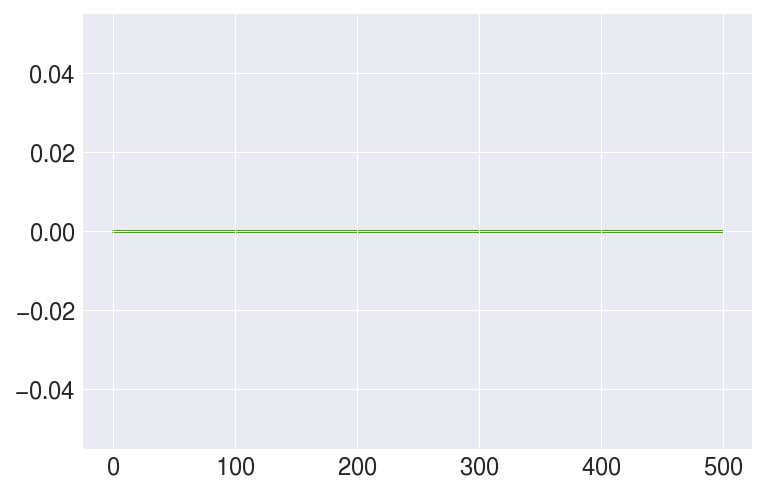

In [14]:
ndim = 3
nsample, nchain = 500, 5

#def target_log_prob(x):
#  return -2. * tf.reduce_sum((x - np.arange(ndim)) ** 2, axis=-1)

#def target_log_prob(x):
#    mean, var= tf.nn.moments(x, axes = [0, 1], keepdims = True)
#    return -tf.reduce_sum(((2*np.pi*var)**(-0.5))*np.exp((-(x - mean)**2)/(2*var)))

def target_log_prob(x):
    mean, var= tf.nn.moments(x, axes = [0, 1], keepdims = True)
    LN2PI = np.log(2.*np.pi)
    #LNSIGMA = np.log(var)

    # normalisation
    norm = -0.5*LN2PI# - LNSIGMA

    chisq = tf.reduce_sum(((2*np.pi*var)**(-0.5))*np.exp((-(x - mean)**2)/(2*var)))

    return norm - 0.5*chisq

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    num_leapfrog_steps=3,
    step_size=.25)

samples, is_accepted = tfp.mcmc.sample_chain(
    kernel=hmc_kernel,
    num_results=nsample,
    num_burnin_steps=50,
    trace_fn=lambda _, pkr: pkr.is_accepted,
    current_state=tf.zeros([nchain, ndim]))

for i in range(ndim):
  plt.plot(samples[..., i], alpha=.25, color=f'C{i}');

In [15]:
sampler = bilby.sampler.Emcee(likelihood, prior)

17:21 bilby INFO    : Search parameters:
17:21 bilby INFO    :   chirp_mass = Uniform(minimum=25.0, maximum=35.0, name='chirp_mass', latex_label='$M$', unit='$M_{\\odot}$', boundary=None)
17:21 bilby INFO    :   mass_ratio = 0.977647
17:21 bilby INFO    :   a_1 = 0.0
17:21 bilby INFO    :   a_2 = 0.0
17:21 bilby INFO    :   tilt_1 = 0.0
17:21 bilby INFO    :   tilt_2 = 0.0
17:21 bilby INFO    :   phi_12 = 0.0
17:21 bilby INFO    :   phi_jl = 0.0
17:21 bilby INFO    :   dec = -1.2232
17:21 bilby INFO    :   ra = 2.19432
17:21 bilby INFO    :   theta_jn = 1.89694
17:21 bilby INFO    :   psi = 0.532268
17:21 bilby INFO    :   luminosity_distance = 412.066
17:21 bilby INFO    :   phase = 5.30408
17:21 bilby INFO    :   geocent_time = 1126259462.4146729
17:21 bilby INFO    : Single likelihood evaluation took 2.114e-03 s
17:21 bilby INFO    : Using sampler Emcee with kwargs {'nwalkers': 500, 'a': 2, 'args': [], 'kwargs': {}, 'postargs': None, 'pool': None, 'live_dangerously': False, 'runtime

In [16]:
sampler.search_parameter_keys, sampler.use_ratio

(['chirp_mass'], False)

In [17]:
likelihood.parameters

{'mass_ratio': 0.977647,
 'a_1': 0.0,
 'a_2': 0.0,
 'tilt_1': 0.0,
 'tilt_2': 0.0,
 'phi_12': 0.0,
 'phi_jl': 0.0,
 'dec': -1.2232,
 'ra': 2.19432,
 'theta_jn': 1.89694,
 'psi': 0.532268,
 'luminosity_distance': 412.066,
 'phase': 5.30408,
 'geocent_time': 1126259462.4146729,
 'chirp_mass': 33.26179822677778}

In [18]:
test_value = 30.

likelihood.parameters.update({'chirp_mass':test_value})
assert likelihood.log_likelihood() == sampler.log_likelihood([test_value])

In [19]:
likelihood.log_likelihood()

-153552775.6428238

In [20]:
chirp_mass_prior = tfd.Uniform(25., 35.)
model_logprob = lambda x: target_log_prob(x) + chirp_mass_prior.log_prob(x)
init_state = chirp_mass_prior.sample()

In [21]:
rwmcmc_kernel = tfp.mcmc.RandomWalkMetropolis(
    model_logprob,
)

In [22]:
def run_sampler(self):
        import dynesty
        import dill
        logger.info("Using dynesty version {}".format(dynesty.__version__))

        if self.kwargs.get("sample", "rwalk") == "rwalk":
            logger.info(
                "Using the bilby-implemented rwalk sample method with ACT estimated walks")
            dynesty.dynesty._SAMPLING["rwalk"] = sample_rwalk_bilby
            dynesty.nestedsamplers._SAMPLING["rwalk"] = sample_rwalk_bilby
            if self.kwargs.get("walks") > self.kwargs.get("maxmcmc"):
                raise DynestySetupError("You have maxmcmc > walks (minimum mcmc)")
            if self.kwargs.get("nact", 5) < 1:
                raise DynestySetupError("Unable to run with nact < 1")
        elif self.kwargs.get("sample") == "rwalk_dynesty":
            self._kwargs["sample"] = "rwalk"
            logger.info(
                "Using the dynesty-implemented rwalk sample method")
        elif self.kwargs.get("sample") == "rstagger_dynesty":
            self._kwargs["sample"] = "rstagger"
            logger.info(
                "Using the dynesty-implemented rstagger sample method")

        self._setup_pool()

        if self.resume:
            self.resume = self.read_saved_state(continuing=True)

        if self.resume:
            logger.info('Resume filbe successfully loaded.')
        else:
            if self.kwargs['live_points'] is None:
                self.kwargs['live_points'] = (
                    self.get_initial_points_from_prior(self.kwargs['nlive'])
                )
            self.sampler = dynesty.NestedSampler(
                loglikelihood=_log_likelihood_wrapper,
                prior_transform=_prior_transform_wrapper,
                ndim=self.ndim, **self.sampler_init_kwargs
            )

        if self.check_point:
            out = self._run_external_sampler_with_checkpointing()
        else:
            out = self._run_external_sampler_without_checkpointing()

        self._close_pool()

        # Flushes the output to force a line break
        if self.kwargs["print_progress"] and self.kwargs["print_method"] == "tqdm":
            self.pbar.close()
            print("")

        check_directory_exists_and_if_not_mkdir(self.outdir)

        if self.nestcheck:
            self.nestcheck_data(out)

        dynesty_result = "{}/{}_dynesty.pickle".format(self.outdir, self.label)
        with open(dynesty_result, 'wb') as file:
            dill.dump(out, file)

        self._generate_result(out)
        self.result.sampling_time = self.sampling_time

        if self.plot:
            self.generate_trace_plots(out)

        return self.result

In [23]:
def loglikelihood_dynesty(theta):
    """
    The log-likelihood function.
    """
    LN2PI = np.log(2.*np.pi)
    LNSIGMA = np.log(sigma)
    
    m, c = theta # unpack the parameters

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq